In [5]:
import numpy as np
from scipy.stats import sigmaclip
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from photutils.aperture.mask import ApertureMask
from photutils.aperture import aperture_photometry
from photutils.isophote import EllipseGeometry
from astropy.wcs import WCS
from astropy import coordinates
import matplotlib.pyplot as plt
from photutils.aperture import EllipticalAperture
from photutils.isophote import Ellipse
from photutils.isophote import build_ellipse_model
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
from photutils.detection import find_peaks

def aperture_stats_tbl(data, apertures,
                       method='exact', sigma_clip=True):

    # Get the masks that will be used to identify our desired pixels.
    masks = apertures.to_mask(method=method)
    if isinstance(masks, ApertureMask): # fix different return types
        masks = [masks]

    # Compute the stats of pixels within the masks
    aperture_stats = [calc_aperture_mmm(data, mask, sigma_clip)
                      for mask in masks]

    aperture_stats = np.array(aperture_stats)


    # Place the array of the x y positions alongside the stats
    stacked = np.hstack([apertures.positions, aperture_stats[0]])
    # Name the columns
    names = ['X','Y','aperture_mean','aperture_median','aperture_mode',
            'aperture_std', 'aperture_area']
    # Make the table
    stats_tbl = Table(data=stacked, names=names)


    return stats_tbl

def calc_aperture_mmm(data, mask, sigma_clip):
    """Helper function to actually calculate the stats for pixels
        falling within some Photutils aperture mask on some array
        of data.
    """
    cutout = mask.cutout(data, fill_value=np.nan)
    if cutout is None:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)
    else:
        values = cutout * mask.data / mask.data
        values = values[~np.isnan(values)]
        if sigma_clip:
            values, clow, chigh = sigmaclip(values, low=3, high=3)

        mean = np.mean(values)
        median = np.median(values)
        std = np.std(values)

        mode = 3 * median - 2 * mean
        actual_area = (~np.isnan(values)).sum()
        return (mean, median, mode, std, actual_area)
    
def iraf_style_photometry(
        phot_apertures,
        bg_apertures,
        data,
        error_array=None,
        bg_method='mode',
        epadu=1.0):

    if bg_method not in ['mean', 'median', 'mode']:
        raise ValueError('Invalid background method, choose either \
                          mean, median, or mode')

    phot = aperture_photometry(data, phot_apertures, error=error_array)
    bg_phot = aperture_stats_tbl(data, bg_apertures, sigma_clip=True)

    if callable(phot_apertures.area):        # Handle photutils change
        ap_area = phot_apertures.area()
    else:
        ap_area = phot_apertures.area
    bg_method_name = 'aperture_{}'.format(bg_method)

    flux = phot['aperture_sum'] - bg_phot[bg_method_name] * ap_area

    # Need to use variance of the sources
    # for Poisson noise term in error computation.
    #
    # This means error needs to be squared.
    # If no error_array error = flux ** .5
    if error_array is not None:
        flux_error = compute_phot_error(phot['aperture_sum_err']**2.0,
                                        bg_phot, bg_method, ap_area,
                                        epadu)
    else:
        flux_error = compute_phot_error(flux, bg_phot,
                                        bg_method, ap_area, epadu)

    mag = -2.5 * np.log10(flux)
    mag_err = 1.0857 * flux_error / flux

    # Make the final table
    X, Y = phot_apertures.positions.T
    stacked = np.stack([X, Y, flux[0], flux_error[0], mag[0], mag_err[0]], axis=0)
    names = ['X', 'Y', 'flux', 'flux_error', 'mag', 'mag_error']

    final_tbl = Table(data=stacked, names=names)
    return final_tbl

def compute_phot_error(
        flux_variance,
        bg_phot,
        bg_method,
        ap_area,
        epadu=1.0):
    """Computes the flux errors using the DAOPHOT style computation"""
    bg_variance_terms = (ap_area * bg_phot['aperture_std'] ** 2. ) \
                        * (1. + ap_area/bg_phot['aperture_area'])
    variance = flux_variance / epadu + bg_variance_terms
    flux_error = variance ** .5
    return flux_error

def galaxy_subtraction(filename, box_corner):
    
    hdul = fits.open(filename+".fits")
    image = hdul[0].data
    hdul.close()
    
    galaxy_image = image[box_corner[2]:box_corner[3], box_corner[0]:box_corner[1]]
    #bkg_sigma = mad_std(galaxy_image)
    mean, median, std = sigma_clipped_stats(galaxy_image, sigma=3.0)
    threshold = median + (5.0 * std)
    s = find_peaks(galaxy_image, threshold, box_size=11)
    s['peak_value'].info.format = '%.8g'
    #daofind = DAOStarFinder(fwhm=4.0, threshold = 10 * bkg_sigma)
    #s = daofind(galaxy_image)
    print(s)
    imagepos = np.transpose((s['x_peak'], s['y_peak']))
    
    geometry = EllipseGeometry(x0=imagepos[0][0], y0=imagepos[0][1], sma=5, eps=0.5,
                           pa=20 * np.pi / 180.0)
    
    aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                          geometry.sma * (1 - geometry.eps),
                          geometry.pa)
    
    plt.imshow(galaxy_image, origin='lower')
    aper.plot(color = 'white')
    plt.show()
    
    ellipse = Ellipse(galaxy_image, geometry)
    print(ellipse)
    isolist = ellipse.fit_image()

    model_image = build_ellipse_model(galaxy_image.shape, isolist)
    residual = galaxy_image - model_image
    
    plt.imshow(residual, origin='lower')
    aper.plot(color = 'white')
    plt.show()
    return(residual)


In [6]:
#Getting instrumental magnitude of SN1A

from photutils.aperture import CircularAnnulus, CircularAperture, ApertureStats
from astropy.visualization import simple_norm
from astropy.io import fits
from astropy import units as u



def singleSourcePhotometry(filename, radius, gain, RA, Dec, ZP, ellipse = False, box_corner = [0]):
    hdul = fits.open(filename+".fits")
    image = hdul[0].data
    hdul.close()
    
    norm = simple_norm(image, 'sqrt')
    plt.imshow(image, origin = 'lower', norm = norm)
    plt.colorbar()
    plt.show()

    if(ellipse == True):
        image[box_corner[2]:box_corner[3],box_corner[0]:box_corner[1]] = galaxy_subtraction(filename, box_corner)

    plt.imshow(image, origin = 'lower', norm = norm)
    plt.colorbar()
    plt.show()

    w = WCS(hdul[0].header)
    sky = coordinates.SkyCoord(RA,Dec, unit=(u.hourangle, u.deg)) 
    imagepos = w.world_to_pixel(sky)
    imagepos = (imagepos[0]-1,imagepos[1]-1)
    circular_aperture = CircularAperture(imagepos, r=radius)
    annulus_aperture = CircularAnnulus(imagepos, r_in = 2*radius, r_out = 3*radius) 

    plt.imshow(image, cmap='gray_r', origin = 'lower', norm = norm)
    circular_aperture.plot(color = 'blue', lw=1.5, alpha = 0.5)
    annulus_aperture.plot(color = 'red', lw = 1.5, alpha = 0.5)
    plt.show()

    result = iraf_style_photometry(circular_aperture, annulus_aperture, image, bg_method='mode', epadu=20*gain)
    print(result)

    #getting instrumental mag and error

    mag_inst = result['mag']
    mag_inst_err = result['mag_error']

    #Getting Callibrated Magnitude


    callibrated_mag = mag_inst + ZP

    return(callibrated_mag, mag_inst_err)


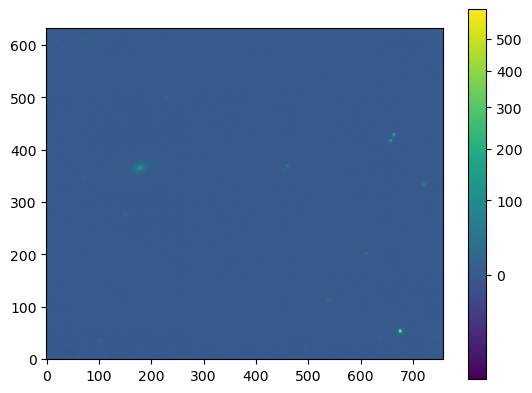

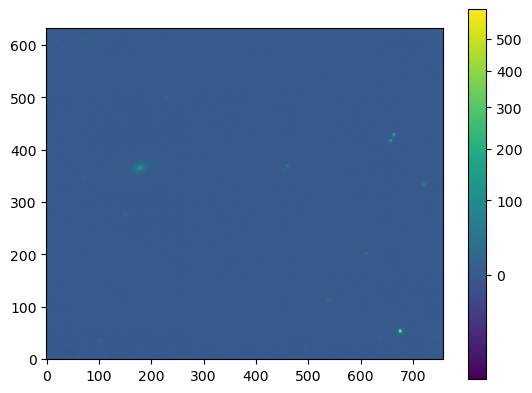

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

In [113]:
singleSourcePhotometry("new-image-1", 6, 0.52, "17:34:32.652", "+49:59:10.46", 22.479000062755848)

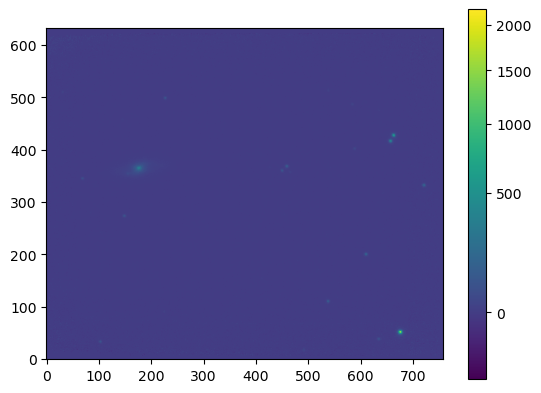

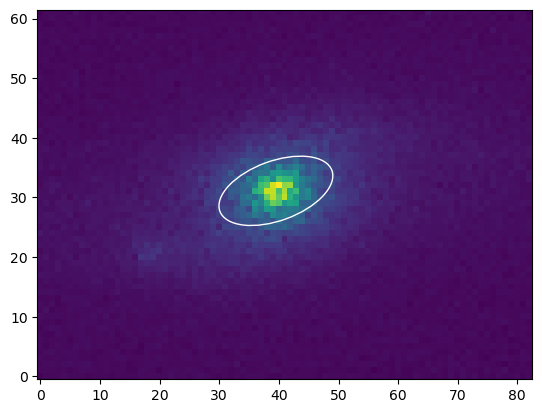

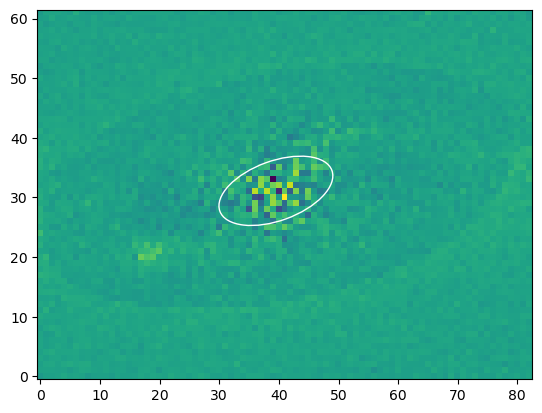

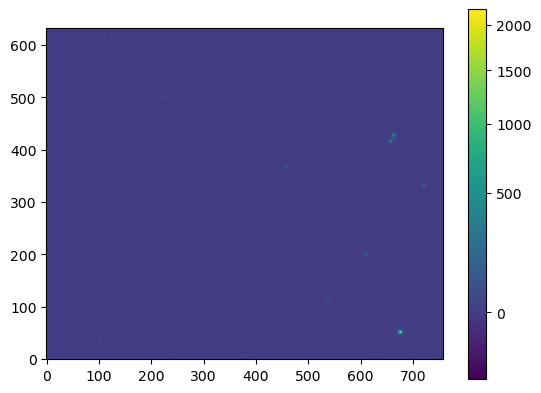

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


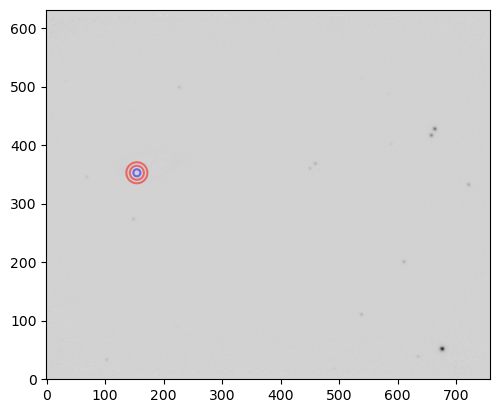

        X                  Y         ...        mag              mag_error     
------------------ ----------------- ... ------------------ -------------------
154.29573716232085 352.6086646035377 ... -5.607320197803473 0.27787433917853555


C:\Users\ranvi\AppData\Local\Temp\ipykernel_15336\3756811340.py:51: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(<Column name='mag' dtype='float64' length=1>
 17.397453243156455,
 <Column name='mag_error' dtype='float64' length=1>
 0.27787433917853555)

In [119]:
singleSourcePhotometry("new-image-2", 6, 0.52, "17:34:32.652", "+49:59:10.46", 23.00477344095993, ellipse = True, box_corner = [137, 220, 333, 395])

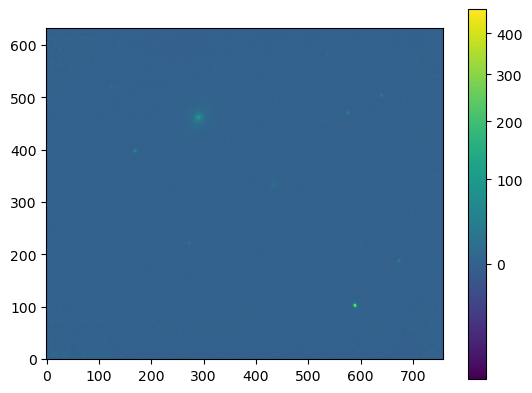

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


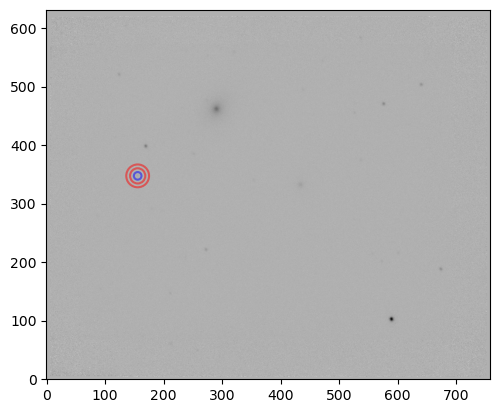

        X                  Y         ...         mag              mag_error     
------------------ ----------------- ... ------------------- -------------------
155.66715428846206 347.3226741693685 ... -5.8170214795413235 0.15293783371877906


C:\Users\ranvi\AppData\Local\Temp\ipykernel_15336\522335242.py:51: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(<Column name='mag' dtype='float64' length=1>
 16.620053245878413,
 <Column name='mag_error' dtype='float64' length=1>
 0.15293783371877906)

In [107]:
singleSourcePhotometry("new-image-3", 6.5, 0.52, "18:29:35.795", "+39:51:14.39", 22.437074725419738)

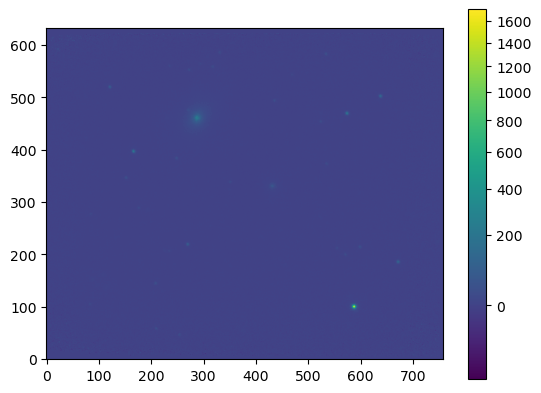

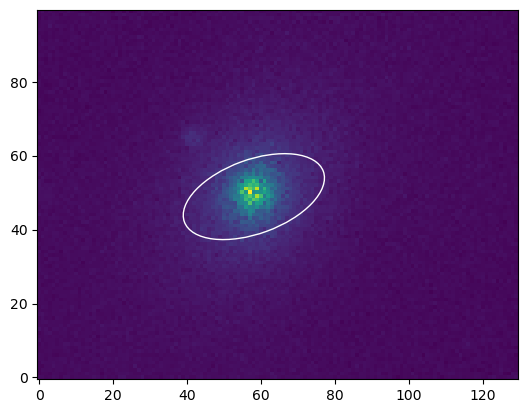

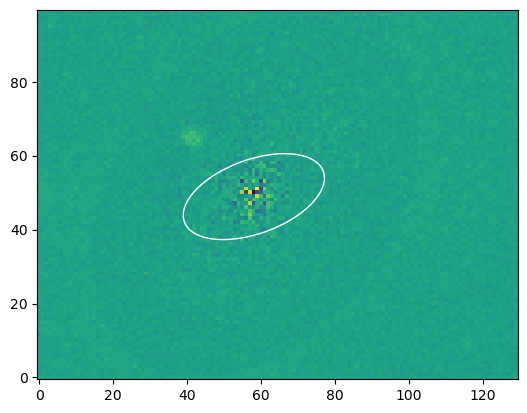

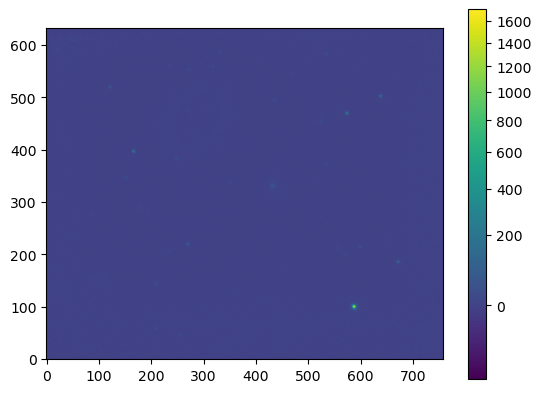

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


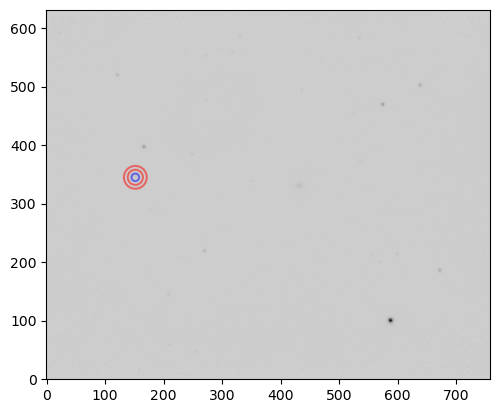

        X                  Y          ...      mag_error      
------------------ ------------------ ... --------------------
151.68383032264646 344.84736650223556 ... 0.030858608414265284


C:\Users\ranvi\AppData\Local\Temp\ipykernel_27868\1517966952.py:51: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(<Column name='mag' dtype='float64' length=1>
 15.497837748126335,
 <Column name='mag_error' dtype='float64' length=1>
 0.030858608414265284)

In [18]:
singleSourcePhotometry("new-image-4", 6.5, 0.52, "18:29:35.795", "+39:51:14.39", 22.98836926340238, ellipse = True, box_corner = [230,360,410,510])

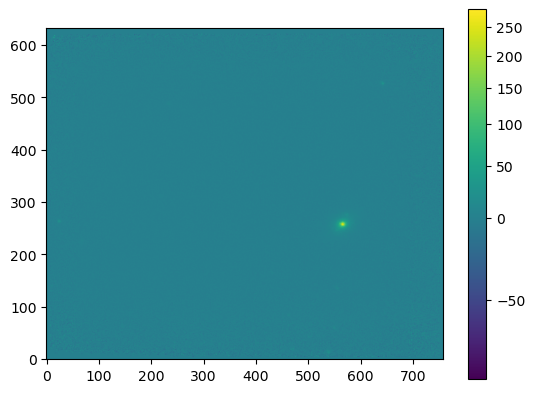

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


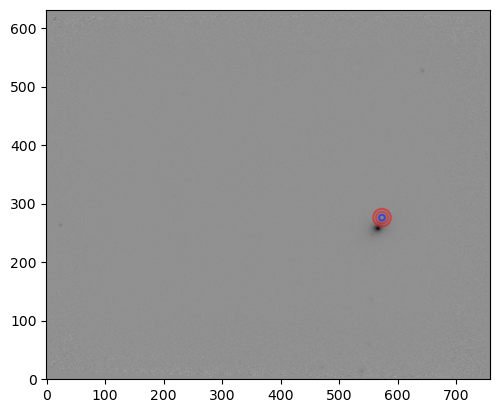

        X                 Y         ...        mag              mag_error     
----------------- ----------------- ... ------------------ -------------------
573.4680863933804 275.9314300858077 ... -7.232548214059014 0.08958431185046171


C:\Users\ranvi\AppData\Local\Temp\ipykernel_15336\1809958708.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(<Column name='mag' dtype='float64' length=1>
 15.399323222412926,
 <Column name='mag_error' dtype='float64' length=1>
 0.08958431185046171)

In [27]:
singleSourcePhotometry("new-image-5", 5, 0.52, "14:46:53.238", "+11:37:32.24", 22.63187143647194)

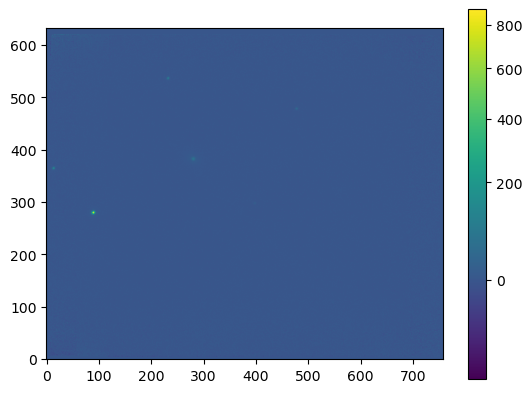

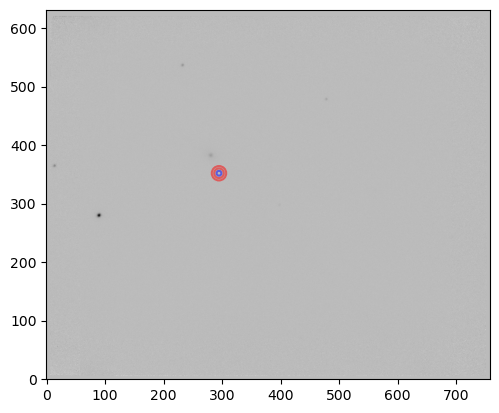

        X                  Y         ...         mag             mag_error     
------------------ ----------------- ... ------------------- ------------------
294.70952933601654 351.7916702348913 ... -4.6262577902493325 0.2988959615920808


C:\Users\ranvi\AppData\Local\Temp\ipykernel_15336\1851905879.py:49: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(<Column name='mag' dtype='float64' length=1>
 17.729318897093428,
 <Column name='mag_error' dtype='float64' length=1>
 0.2988959615920808)

In [77]:
singleSourcePhotometry("new-image-6", 4.1, 0.52, "09:02:14.957", "+46:24:56.73", 22.35557668734276)

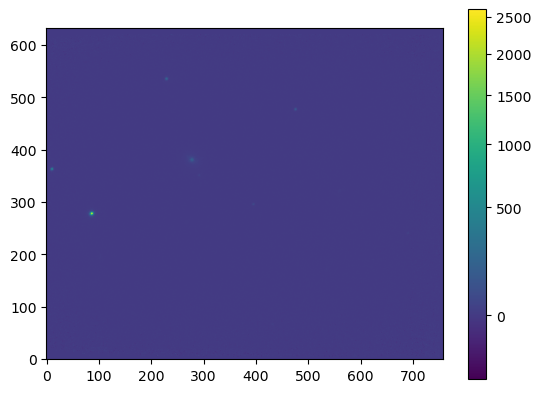

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


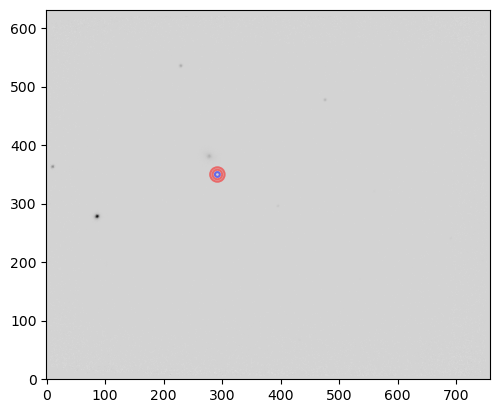

C:\Users\ranvi\AppData\Local\Temp\ipykernel_15336\1851905879.py:49: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


        X                 Y          ...        mag              mag_error     
----------------- ------------------ ... ------------------ -------------------
291.9849502710882 349.65216225884905 ... -6.624952180204984 0.04789122140244628


(<Column name='mag' dtype='float64' length=1>
 16.330348400733058,
 <Column name='mag_error' dtype='float64' length=1>
 0.04789122140244628)

In [78]:
singleSourcePhotometry("new-image-7", 4.1, 0.52, "09:02:14.957", "+46:24:56.73", 22.95530058093804)

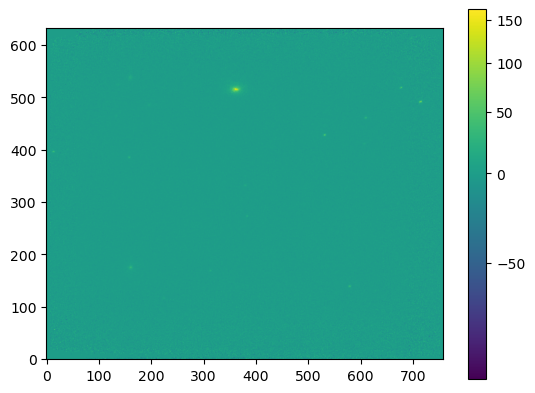

x_peak y_peak peak_value
------ ------ ----------
    21     24  163.63973


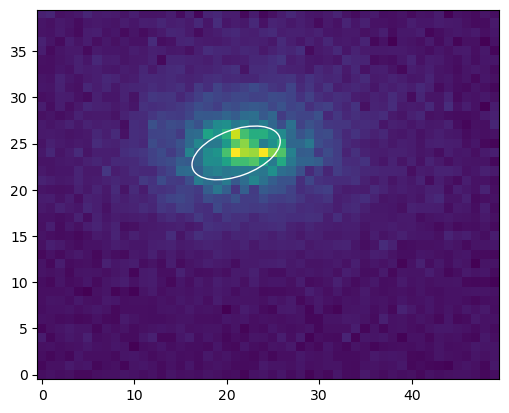

C:\Users\ranvi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ranvi\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\ranvi\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ranvi\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\ranvi\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


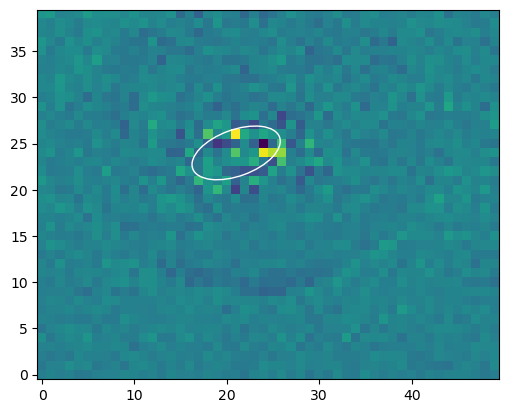

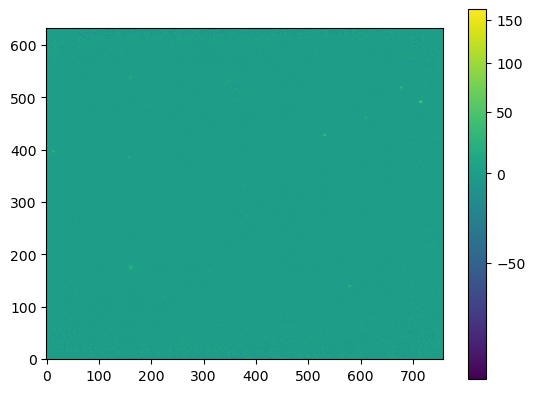

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


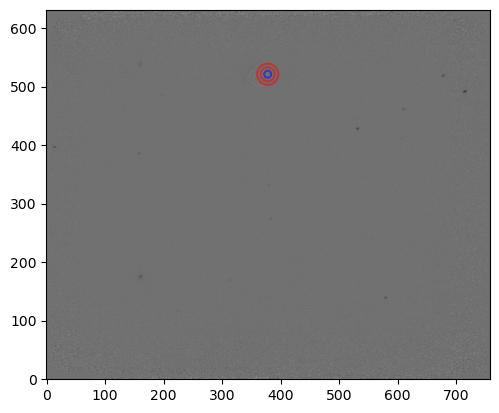

        X                  Y                flux            flux_error     mag      mag_error     
------------------ ----------------- ------------------ ------------------ --- -------------------
377.98925341291465 521.0827066969463 -34.28951932525446 39.591799427158435 nan -1.2535846953797136


C:\Users\ranvi\AppData\Local\Temp\ipykernel_32880\2409800302.py:53: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_32880\2409800302.py:102: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


(<Column name='mag' dtype='float64' length=1>
 nan,
 <Column name='mag_error' dtype='float64' length=1>
 -1.2535846953797136)

In [7]:
singleSourcePhotometry("new-image-8", 6, 0.52, "12:32:11.082", "+76:49:24.94", 22.878238137098396, ellipse = True , box_corner= [340,390,490,530])

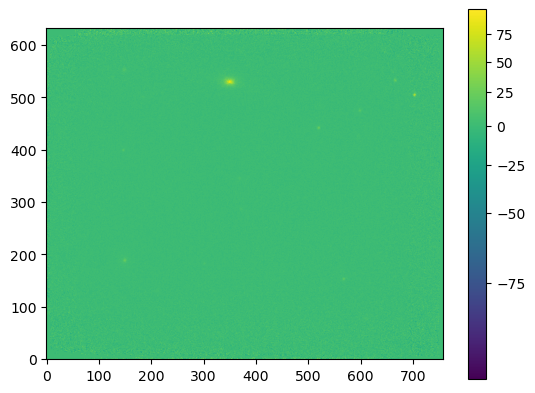

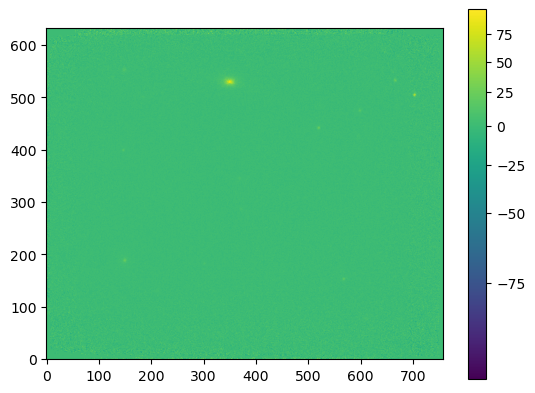

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


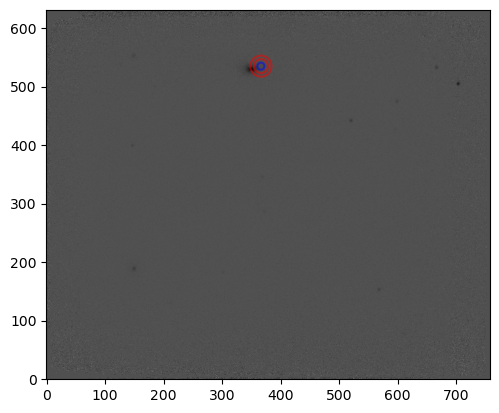

C:\Users\ranvi\AppData\Local\Temp\ipykernel_15336\2788660073.py:51: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


        X                  Y         ...        mag              mag_error     
------------------ ----------------- ... ------------------ -------------------
366.45404396142567 534.9153907831286 ... -6.459865411186085 0.12193956674043423


(<Column name='mag' dtype='float64' length=1>
 16.418372725912313,
 <Column name='mag_error' dtype='float64' length=1>
 0.12193956674043423)

In [129]:
singleSourcePhotometry("new-image-9", 6, 0.52, "12:32:11.082", "+76:49:24.94", 22.878238137098396, ellipse = False, box_corner= [320,380,500,550])

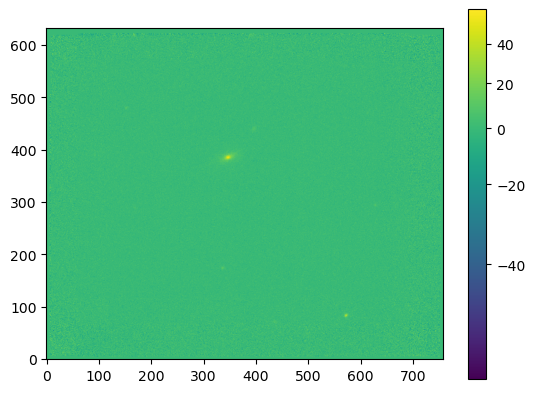

x_peak y_peak peak_value
------ ------ ----------
    47     34  59.771009


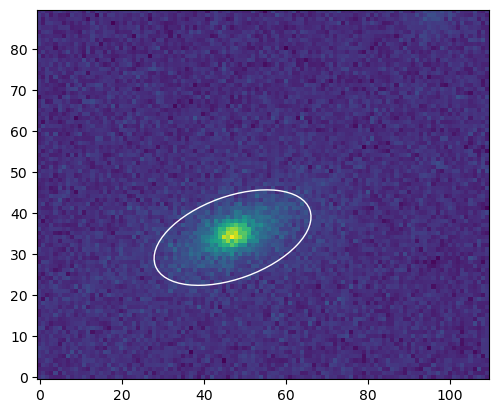

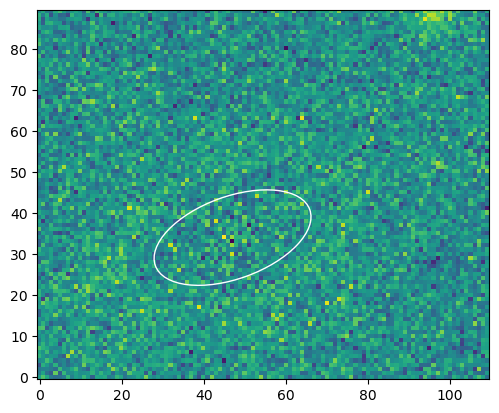

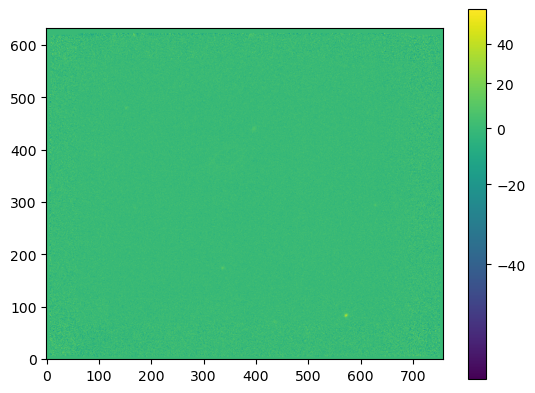

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


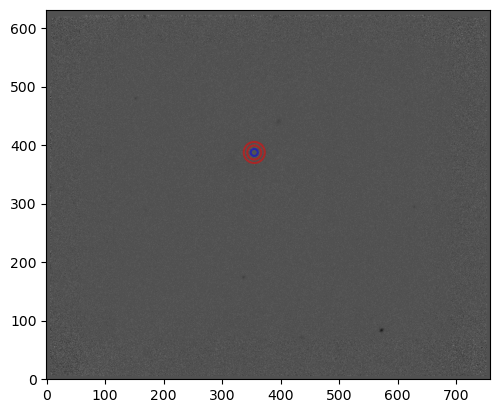

        X                 Y                flux            flux_error     mag      mag_error     
------------------ ---------------- ------------------ ------------------ --- -------------------
355.02970436619046 387.316673303789 -42.15150893058748 28.373079770977565 nan -0.7308078284475547


C:\Users\ranvi\AppData\Local\Temp\ipykernel_24724\2235260518.py:53: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_24724\2235260518.py:102: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


(<Column name='mag' dtype='float64' length=1>
 nan,
 <Column name='mag_error' dtype='float64' length=1>
 -0.7308078284475547)

In [9]:
singleSourcePhotometry("new-image-10", 6, 0.52, "14:18:13.250", "-03:07:15.17", 22.44792708155295, ellipse = True, box_corner= [300,410,350,440])

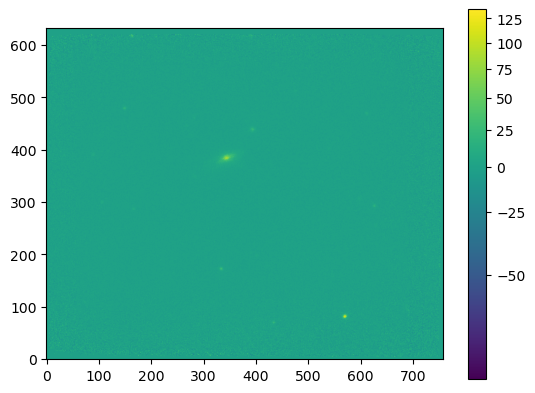

x_peak y_peak peak_value
------ ------ ----------
    75     43  108.27164


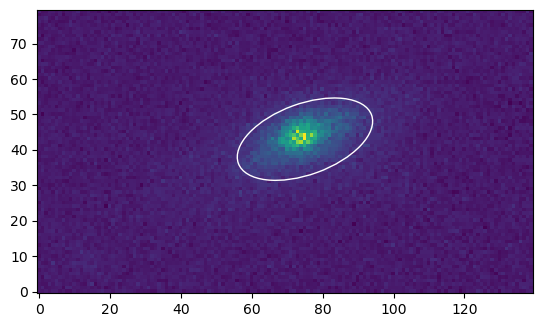

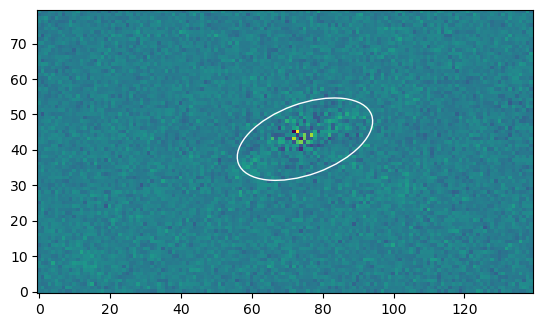

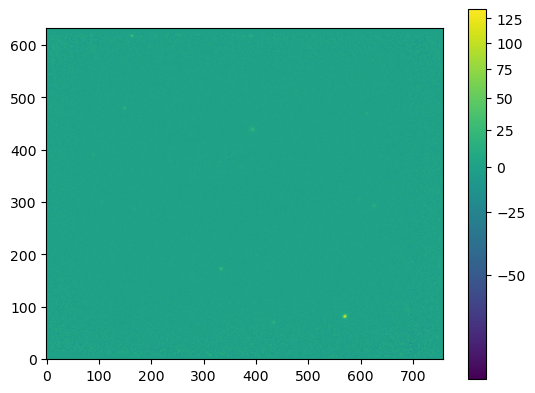

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


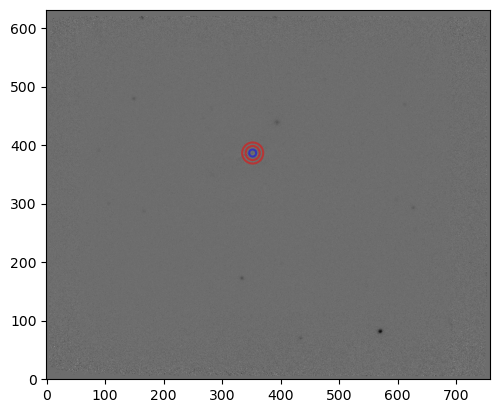

        X                  Y                 flux            flux_error            mag             mag_error     
------------------ ------------------ ------------------ ------------------ ------------------ ------------------
352.31302003180315 386.38473331790385 31.412700908578707 28.913548055955374 -3.742763198148662 0.9993231468924041


C:\Users\ranvi\AppData\Local\Temp\ipykernel_24724\2235260518.py:53: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(<Column name='mag' dtype='float64' length=1>
 19.304977216068295,
 <Column name='mag_error' dtype='float64' length=1>
 0.9993231468924041)

In [10]:
singleSourcePhotometry("new-image-11", 6, 0.52, "14:18:13.250", "-03:07:15.17", 23.047740414216957, ellipse = True, box_corner= [270,410,340,420])

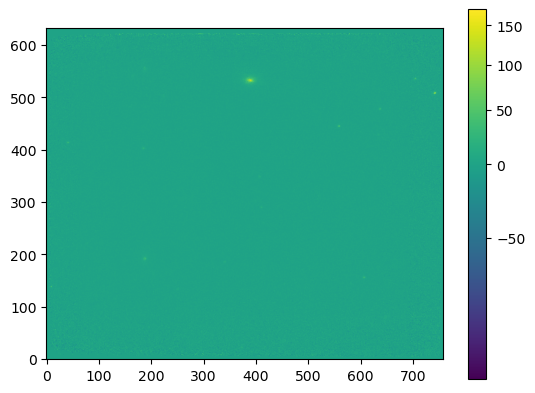

x_peak y_peak peak_value
------ ------ ----------
    50     32  151.26541


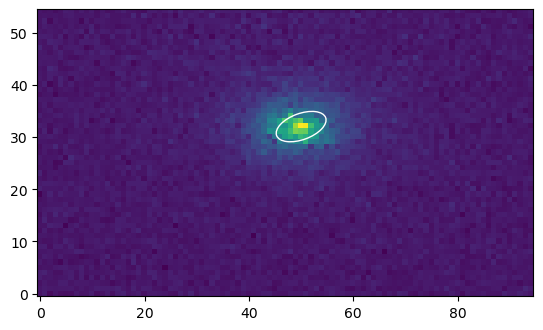

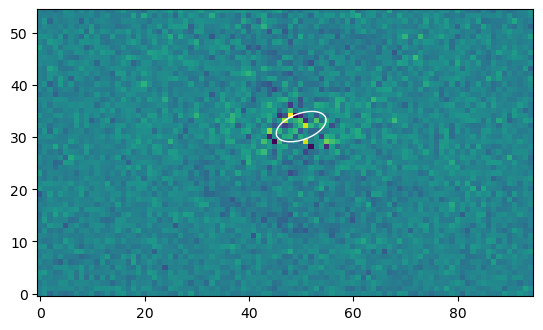

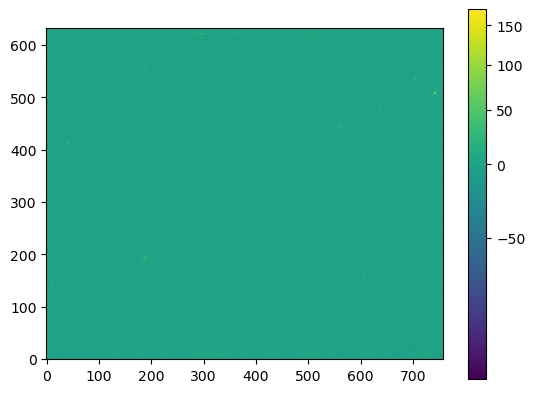

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


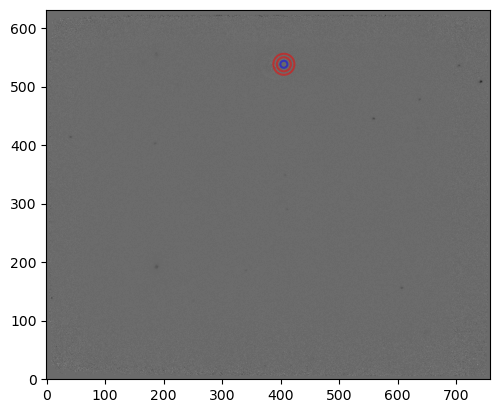

        X                Y                flux           flux_error           mag             mag_error     
----------------- ---------------- ----------------- ----------------- ------------------ ------------------
405.6669384316437 538.125120194967 71.84169868719542 38.45805062836876 -4.640941481536539 0.5811931834883228


C:\Users\ranvi\AppData\Local\Temp\ipykernel_32880\2409800302.py:53: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(<Column name='mag' dtype='float64' length=1>
 18.20362653319202,
 <Column name='mag_error' dtype='float64' length=1>
 0.5811931834883228)

In [8]:
singleSourcePhotometry("new-image-12", 6, 0.52, "12:32:11.082", "+76:49:24.94", 22.84456801472856, ellipse = True, box_corner= [340,435,500,555])

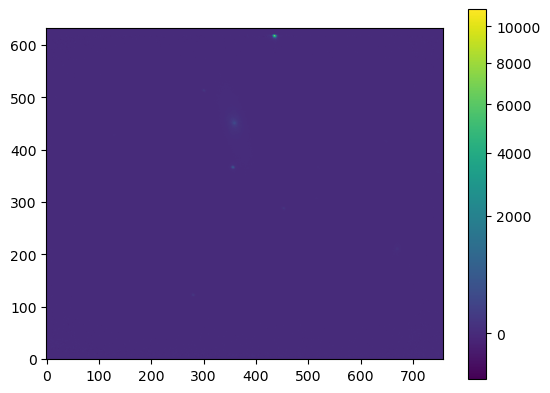

x_peak y_peak peak_value
------ ------ ----------
    48     61  472.97528


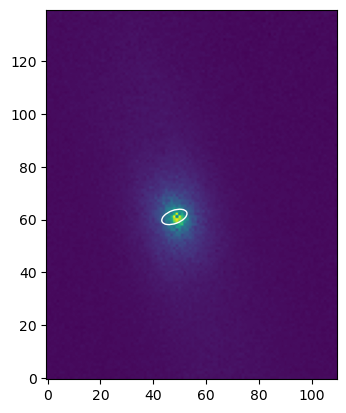

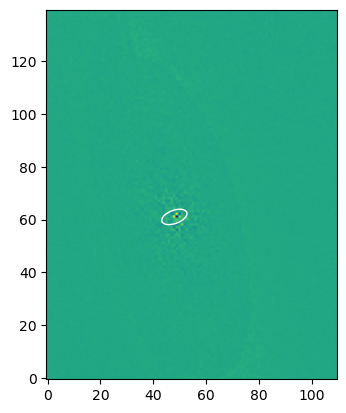

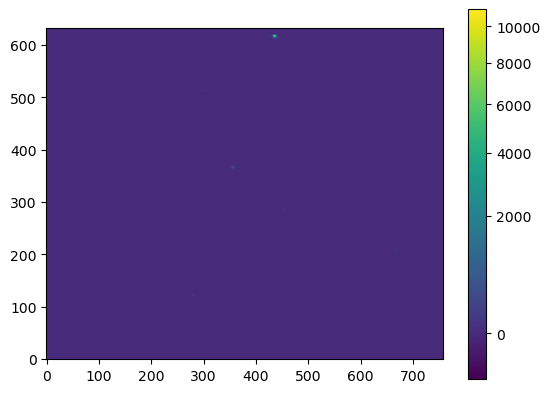

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


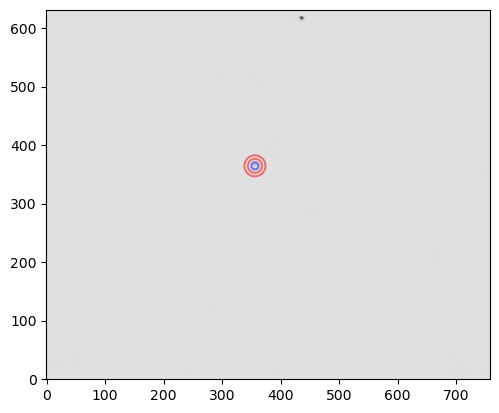

       X                 Y                 flux            flux_error           mag              mag_error      
---------------- ------------------ ------------------ ----------------- ------------------ --------------------
356.198982209284 364.43698350141744 13383.921064432869 48.43091461514319 -10.31645841645968 0.003928702488943516


C:\Users\ranvi\AppData\Local\Temp\ipykernel_32880\2409800302.py:53: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(<Column name='mag' dtype='float64' length=1>
 12.528109598268879,
 <Column name='mag_error' dtype='float64' length=1>
 0.003928702488943516)

In [11]:
singleSourcePhotometry("new-image-13", 6, 0.52, "11:06:32.160", "+11:22:42.38", 22.84456801472856, ellipse = True, box_corner = [310,420,390,530])

In [23]:
hdul = fits.open("new-image-13"+".fits")
image = hdul[0].data
hdul.close()

w = WCS(hdul[0].header)
sky = coordinates.SkyCoord("11:06:32.160","+11:22:42.38", unit=(u.hourangle, u.deg)) 
imagepos = w.world_to_pixel(sky)
    
print(imagepos)

(array(357.19898221), array(365.4369835))


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


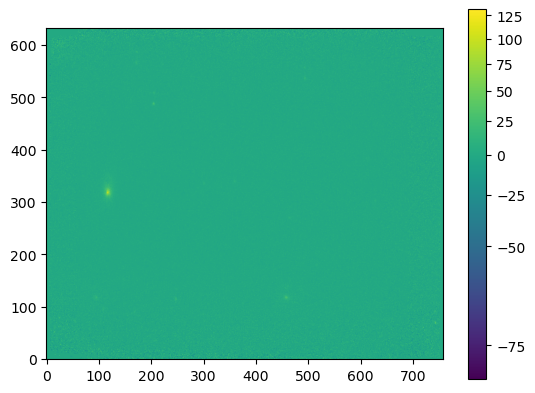

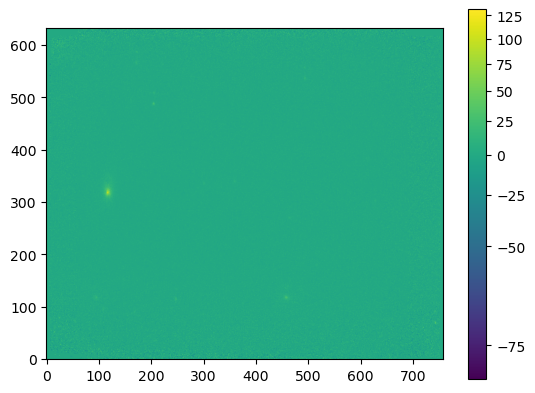

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


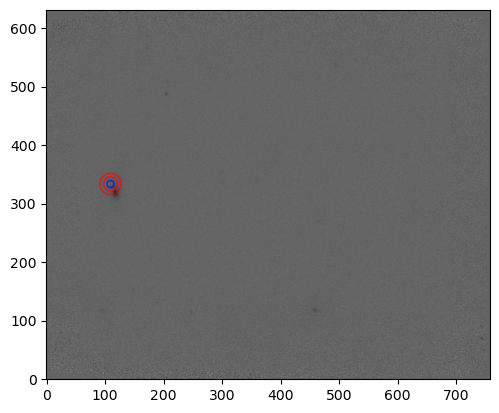

        X                 Y                flux           flux_error           mag              mag_error     
------------------ ---------------- ----------------- ----------------- ------------------ -------------------
109.28259349655181 333.476548736131 540.1758758050573 57.17749165580396 -6.831337961852332 0.11492109416805832


C:\Users\ranvi\AppData\Local\Temp\ipykernel_24724\2235260518.py:53: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(<Column name='mag' dtype='float64' length=1>
 15.270859374576366,
 <Column name='mag_error' dtype='float64' length=1>
 0.11492109416805832)

In [14]:
singleSourcePhotometry("new-image-14", 6, 0.52, "12:32:11.082", "+76:49:24.94", 22.1021973364287, ellipse = False, box_corner= [85,150,280,360])

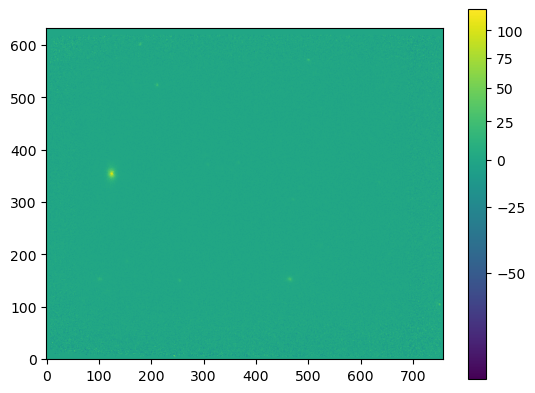

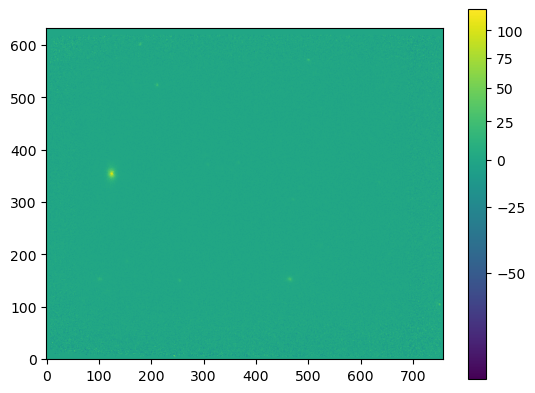

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


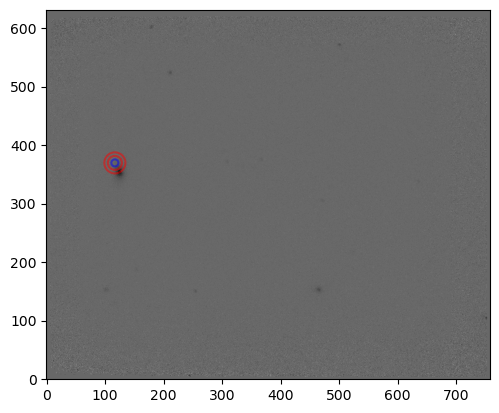

        X                  Y          ...        mag              mag_error     
------------------ ------------------ ... ------------------ -------------------
116.69042097302619 369.51020360909223 ... -6.459602631307527 0.10585588784115048


C:\Users\ranvi\AppData\Local\Temp\ipykernel_27868\2058053372.py:51: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(<Column name='mag' dtype='float64' length=1>
 15.864360765731176,
 <Column name='mag_error' dtype='float64' length=1>
 0.10585588784115048)

In [7]:
singleSourcePhotometry("new-image-15", 6, 0.52, "12:32:11.082", "+76:49:24.94", 22.323963397038703, ellipse = False, box_corner= [85,150,280,360])

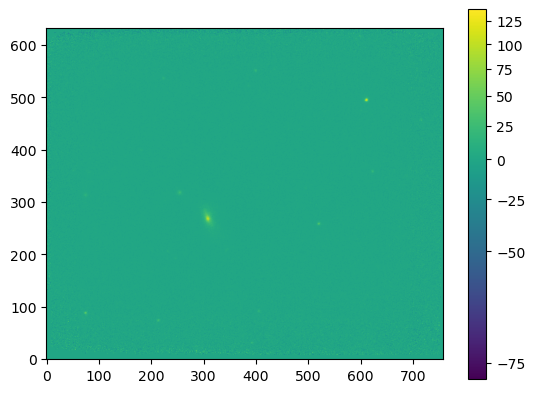

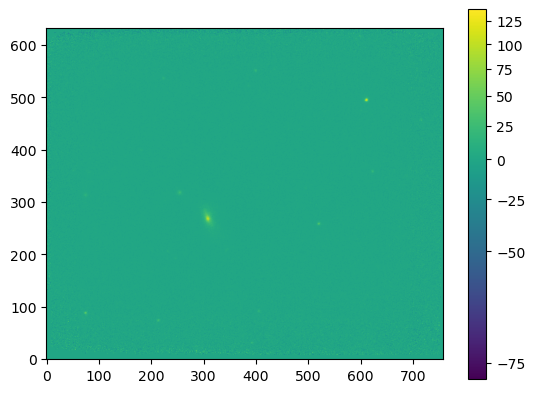

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


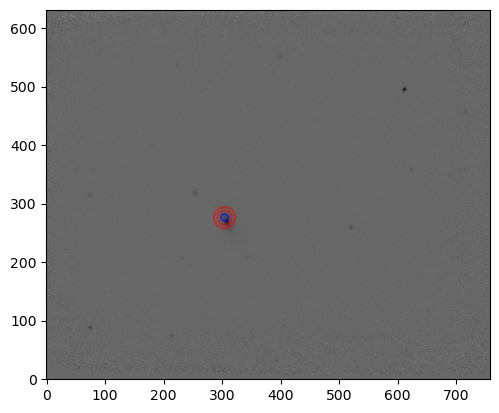

        X                 Y         ...        mag              mag_error      
----------------- ----------------- ... ------------------ --------------------
304.3081448264281 275.8378771770684 ... -8.556147817576491 0.019037489100844993


C:\Users\ranvi\AppData\Local\Temp\ipykernel_27868\1517966952.py:51: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(<Column name='mag' dtype='float64' length=1>
 14.464321889984596,
 <Column name='mag_error' dtype='float64' length=1>
 0.019037489100844993)

In [12]:
singleSourcePhotometry("new-image-16", 6, 0.52, "14:18:13.250", "-03:07:15.17", 23.020469707561087, ellipse = False, box_corner= [280,340,240,300])

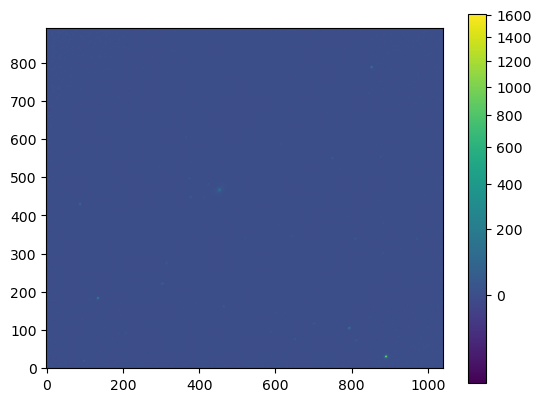

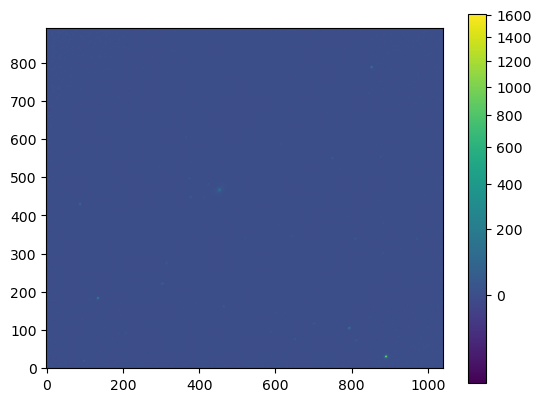

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


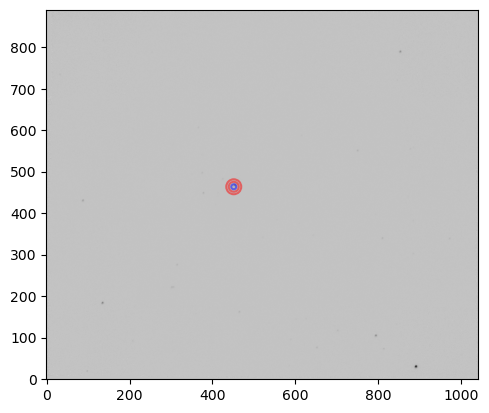

        X                  Y         ...        mag              mag_error     
------------------ ----------------- ... ------------------ -------------------
451.27679313901433 463.6023961384269 ... -9.373806701531578 0.00807497260797429


C:\Users\ranvi\AppData\Local\Temp\ipykernel_27868\1517966952.py:51: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(<Column name='mag' dtype='float64' length=1>
 12.880905266660196,
 <Column name='mag_error' dtype='float64' length=1>
 0.00807497260797429)

In [13]:
singleSourcePhotometry("new-image-17", 6, 0.52, "22:30:41.062", "+39:17:30.21", 22.254711968191774, ellipse = False, box_corner= [280,340,240,300])

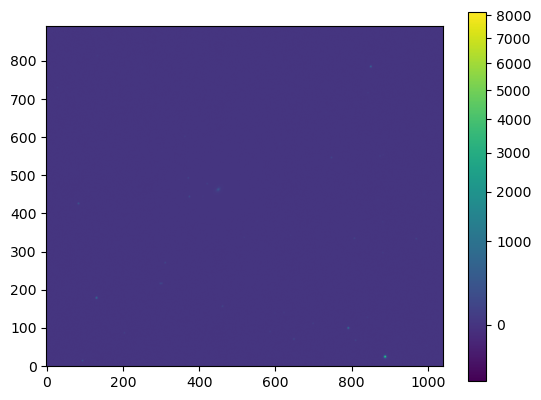

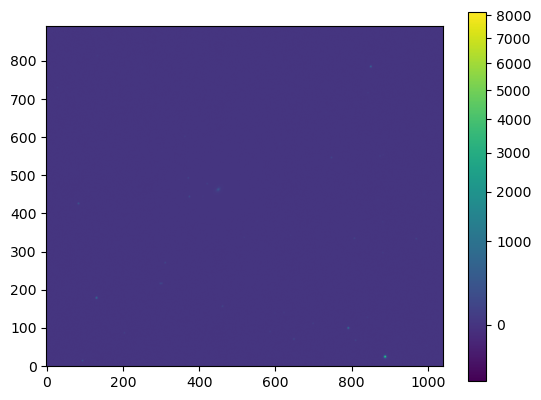

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


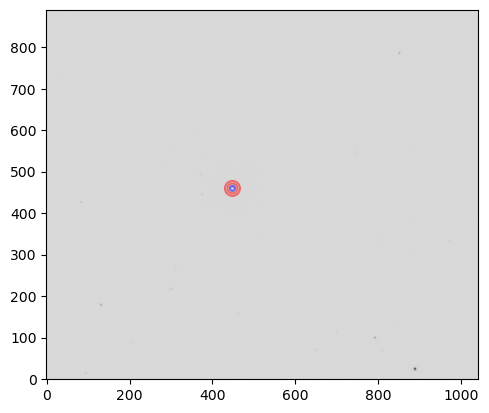

        X                 Y                 flux            flux_error             mag              mag_error      
----------------- ------------------ ------------------ ------------------ ------------------- --------------------
448.1718971518657 459.60332520095545 12623.793682409694 58.295125992205726 -10.252974720025529 0.005013629015335464


C:\Users\ranvi\AppData\Local\Temp\ipykernel_24724\2235260518.py:53: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(<Column name='mag' dtype='float64' length=1>
 12.618347627277059,
 <Column name='mag_error' dtype='float64' length=1>
 0.005013629015335464)

In [18]:
singleSourcePhotometry("new-image-18", 6, 0.52, "22:30:41.062", "+39:17:30.21", 22.871322347302588, ellipse = False, box_corner= [280,340,240,300])